In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
from sklearn.ensemble import RandomForestRegressor
sns.set()

import statsmodels.api as sm
%matplotlib inline

# 設定
import warnings
warnings.filterwarnings("ignore")

In [2]:
item=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/items.csv")
item_categories=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/item_categories.csv")
sales_train=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sales_train.csv")
shops=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/shops.csv")
test_csv=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/test.csv")
sample_submission=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sample_submission.csv")

In [3]:
# 日付カラムを正しくフォーマットする
sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x,"%d.%m.%Y"))
# 確認
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
#agg()の引数に、適用したい処理を表す文字列や呼び出し可能オブジェクトのリストを指定
monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [5]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

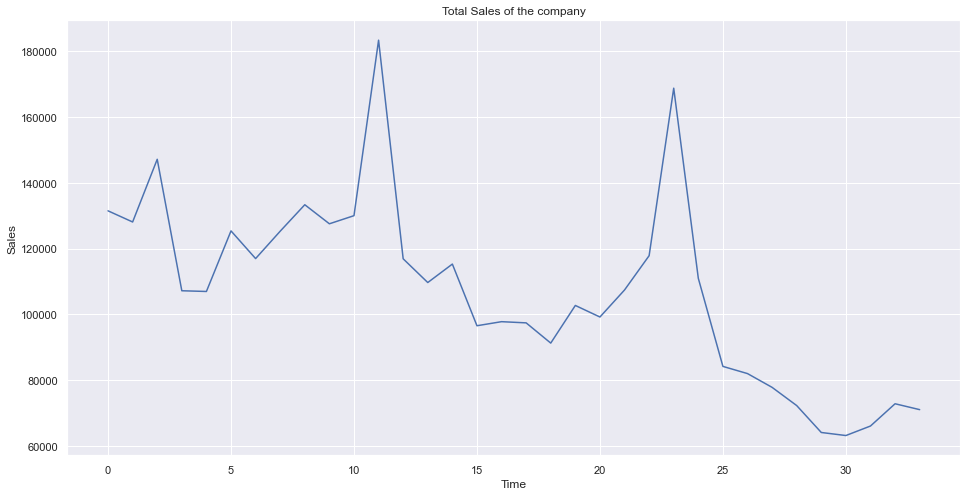

In [6]:
df=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
df.astype("float")
plt.figure(figsize=(16,8))
plt.title("Total Sales of the company")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(df);

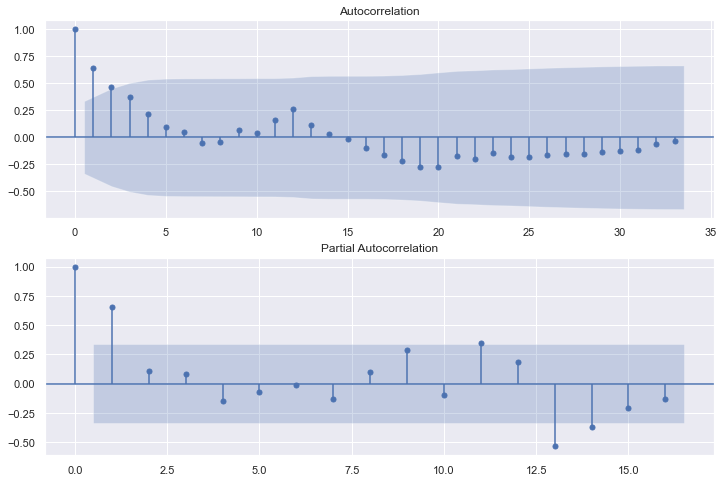

In [7]:
#自己相関、偏自己相関グラフ
#自己相関とは前期と今期がどれだけ似ているかを表す。
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df, lags=33, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df, lags=16, ax=ax2)

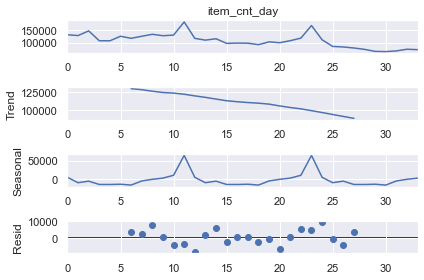

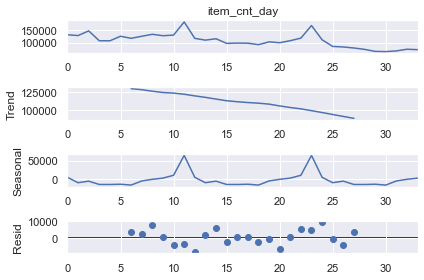

In [8]:
# データをトレンドと季節成分に分解
seasonal_decompose_res=sm.tsa.seasonal_decompose(df,freq=12)
seasonal_decompose_res.plot()

In [9]:
#データを定常にしていく
#トレンド成分が含まれているデータは「非定常」であるといい、分析がしにくい状態になっている。
#それに対して「定常」なデータは分析がしやすいのでデータを定常な状態にしたい。
#通常、非定常なデータは差分をとることでトレンド成分を取り除き、定常にすることができる。
#また、データが定常であるかは「単位根検定」を行うことで調べることができる。

# トレンド項あり（１次まで）、定数項あり
ct=sm.tsa.stattools.adfuller(df,regression="ct")
# トレンド項なし、定数項あり
c=sm.tsa.stattools.adfuller(df,regression="c")
# トレンド項なし、定数項なし
nc=sm.tsa.stattools.adfuller(df,regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")


ct:
1.7765995531964308e-06
---------------------------------------------------------------------------------------------------------------
c:
0.1429525769929046
---------------------------------------------------------------------------------------------------------------
nc:
0.2863643715632933
---------------------------------------------------------------------------------------------------------------


In [11]:
diff=df.diff()
diff=diff.dropna()

# トレンド項あり（１次まで）、定数項あり
ct=sm.tsa.stattools.adfuller(diff,regression="ct")
# トレンド項なし、定数項あり
c=sm.tsa.stattools.adfuller(diff,regression="c")
# トレンド項なし、定数項なし
nc=sm.tsa.stattools.adfuller(diff,regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")


ct:
8.792054325916228e-22
---------------------------------------------------------------------------------------------------------------
c:
1.6863951222874175e-25
---------------------------------------------------------------------------------------------------------------
nc:
6.206677306098448e-12
---------------------------------------------------------------------------------------------------------------


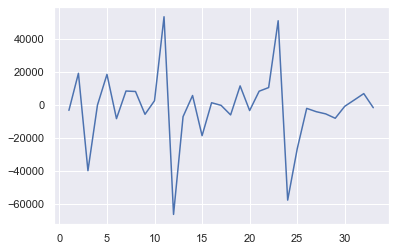

In [12]:
plt.plot(diff)

In [13]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p=3
max_q=3
max_d=2
max_sp=1
max_sq=1
max_sd=1

pattern=max_p*(max_d +1)*(max_q +1)*(max_sp +1)*(max_sq +1)*(max_sd +1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1,max_p+1):
    for d in range(0, max_d+1):
        for q in range(0, max_q+1):
            for sp in range(0, max_sp+1):
                for sd in range(0, max_sd+1):
                    for sq in range(0, max_sq+1):
                        sarima = sm.tsa.SARIMAX(
                            df,order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity=False, 
                            enforce_invertibility=False
                        ).fit()
                        modelSelection.loc[num]["model"]="order=("+ str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.loc[num]["aic"]=sarima.aic
                        num=num+1

In [14]:
modelSelection.sort_values(by="aic").head()

,model,aic
187,"order=(2,2,3), season=(0,1,1)",91.0141
283,"order=(3,2,3), season=(0,1,1)",91.5447
287,"order=(3,2,3), season=(1,1,1)",92.8397
191,"order=(2,2,3), season=(1,1,1)",93.1377
91,"order=(1,2,3), season=(0,1,1)",94.643


In [16]:
#SARIMA_2_2_3_011=sm.tsa.SARIMAX(ts,order=(2,2,3),seasonal_order=(0,1,1,12)).fit()
#SARIMA_3_2_3_011=sm.tsa.SARIMAX(ts,order=(3,2,3),seasonal_order=(0,1,1,12)).fit()
#SARIMA_3_2_3_111=sm.tsa.SARIMAX(ts,order=(3,2,3),seasonal_order=(1,1,1,12)).fit()
#SARIMA_2_2_3_111=sm.tsa.SARIMAX(ts,order=(2,2,3),seasonal_order=(1,1,1,12)).fit()
SARIMA_1_2_3_011=sm.tsa.SARIMAX(df, order=(1,2,3), seasonal_order=(0,1,1,12)).fit()

In [17]:
# Ljungbox検定
#棄却したくないのでこのコードの出力結果は空のデータフレームを採用
#ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_2_2_3_011.resid, lags=10)
#ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_2_3_011.resid, lags=10)
#ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_2_3_111.resid, lags=10)
#ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_2_2_3_111.resid, lags=10)

ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_1_2_3_011.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

,p-value


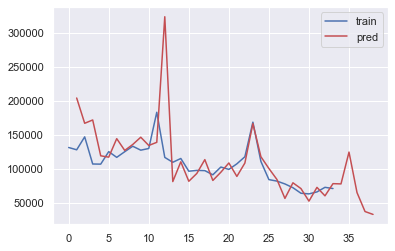

In [19]:
# 仮予測
tmp_pred=SARIMA_1_2_3_011.predict(1,38)
# 実データと予測結果の図示
plt.plot(df, label="train")
plt.plot(tmp_pred, "r", label="pred")
plt.legend()

In [20]:
# 予測
pred=SARIMA_1_2_3_011.predict(34)
pred=float(pred)
print(pred)

77868.0772528974


In [22]:
ratio=[0*i for i in range(34)]

for i in range(34):
    ratio[i]=pred/df[i]


In [23]:
sales_train2=sales_train.copy()
sales_train2.drop(["date","item_price"], axis=1, inplace=True)
sales_train2

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
...,...,...,...,...
2935844,33,25,7409,1.0
2935845,33,25,7460,1.0
2935846,33,25,7459,1.0
2935847,33,25,7440,1.0


In [24]:
sales_train2=sales_train2.groupby(["date_block_num","shop_id","item_id"]).sum()
sales_train2=sales_train2.pivot_table(index=["shop_id","item_id"], columns="date_block_num", values="item_cnt_day", fill_value=0)
sales_train2.reset_index(inplace=True)
sales_train2

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


In [25]:
x1=sales_train2.values
x2=sales_train2.keys()

#各ショップで売れたアイテムの総数
item_list=[0*i for i in range(424124)]

for i in range(424124):
    for j in range(34):
        item_list[i]+=(x1[i][j+2])*ratio[j]

In [26]:
shop_id=sales_train2.loc[:,"shop_id"]
item_id=sales_train2.loc[:,"item_id"]
df_x=pd.DataFrame(item_list)
df_shop_id=pd.DataFrame(shop_id)
df_item_id=pd.DataFrame(item_id)
df=pd.concat([df_shop_id,df_item_id,df_x],axis=1)
train=df.rename(columns={df.columns[2]:"item_cnt_month"})
train

,shop_id,item_id,item_cnt_month
0,0,30,18.845424
1,0,31,6.687086
2,0,32,9.632653
3,0,33,3.600493
4,0,35,9.103084
...,...,...,...
424119,59,22154,0.592247
424120,59,22155,0.665733
424121,59,22162,15.377208
424122,59,22164,6.032489


In [28]:
train2=[0*i for i in range(424124)]

for i in range(424124):
    train2[i]=((train["item_cnt_month"][i])/34)
    
train["item_cnt_month"]=train2
train

,shop_id,item_id,item_cnt_month
0,0,30,0.554277
1,0,31,0.196679
2,0,32,0.283313
3,0,33,0.105897
4,0,35,0.267738
...,...,...,...
424119,59,22154,0.017419
424120,59,22155,0.019580
424121,59,22162,0.452271
424122,59,22164,0.177426


In [29]:
#trainのデータ
train_x=train.drop(columns=["item_cnt_month"])
train_y=train["item_cnt_month"]

In [30]:
clf=RandomForestRegressor(n_jobs=-1, random_state=2525)
clf.fit(train_x,train_y)

RandomForestRegressor(n_jobs=-1, random_state=2525)

In [31]:
y_predict=clf.predict(test_csv.drop(columns="ID"))

In [32]:
result=np.round(y_predict)
sample_submission["item_cnt_month"]=result
sample_submission.to_csv("prediction6.csv", index=False)

In [33]:
sample_submission

,ID,item_cnt_month
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0
